---
# Examples of multi-layer perceptron (MLP) classifications using different optimizing methods
---

In this script, we show two examples of MLP classifications applied to a 2-D dataset made of two overlapping elliptical 
blobs. 

We describe the optimization behaviours and the classification results of MLP trained with the stochastic gradient 
descent (SGD) and the SGD-with-momentum optimizers. 


In [1]:
print(__doc__)

# Author: Pierre Gravel <pierre.gravel@iid.ulaval.ca>
# License: BSD

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import colors

from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_validate
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

from sklearn.datasets import make_blobs
from scipy import stats
import scipy as sp
import scipy.spatial
from scipy.spatial.distance import cdist

from numpy import unravel_index

import seaborn as sns
sns.set()

cm_dim = ListedColormap(['#FFAAAA', '#FFFFAA'])
cm_bright = ListedColormap(['#FF0000', '#FFFF00'])

# Used for reproductibility of the results
np.random.seed(42)


Automatically created module for IPython interactive environment


## Part I:  Dataset generation

We use a dataset made of two overlapping ellipsoidal gaussian blobs.

In [2]:
# Number of datapoints in each cluster
N_samples = 1000


# First gaussian 
center = [[0, 0]]
X, y = make_blobs(n_samples=N_samples, centers=center)
transformation = [[1, 0.2], [0.2, 1]]
X = np.dot(X, transformation)

# Second gaussian 
center = [[0, 0]]
X2, y2 = make_blobs(n_samples=N_samples, centers=center)
transformation = [[1, -0.5], [-0.5, 1]]
X2 = np.dot(X2, transformation) + [[2,2]]
y2 = y2 + 1

X = np.vstack((X, X2))
y = np.hstack((y, y2))


Normalize the data and generate a spatial grid where the class will be evaluated locally

In [3]:
nbins = 250

X = MinMaxScaler().fit_transform(X) - 0.5
x_min = 1.1 * X[:,0].min()
x_max = 1.1 * X[:,0].max()
y_min = 1.1 * X[:,1].min()
y_max = 1.1 * X[:,1].max()

# Generate a spatial grid 
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nbins), np.linspace(y_min, y_max, nbins))
Xgrid = np.c_[xx.ravel(), yy.ravel()]

Split the dataset into a training dataset (80 %) and a test dataset (20 %) 

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,train_size=0.8)

Display the dataset

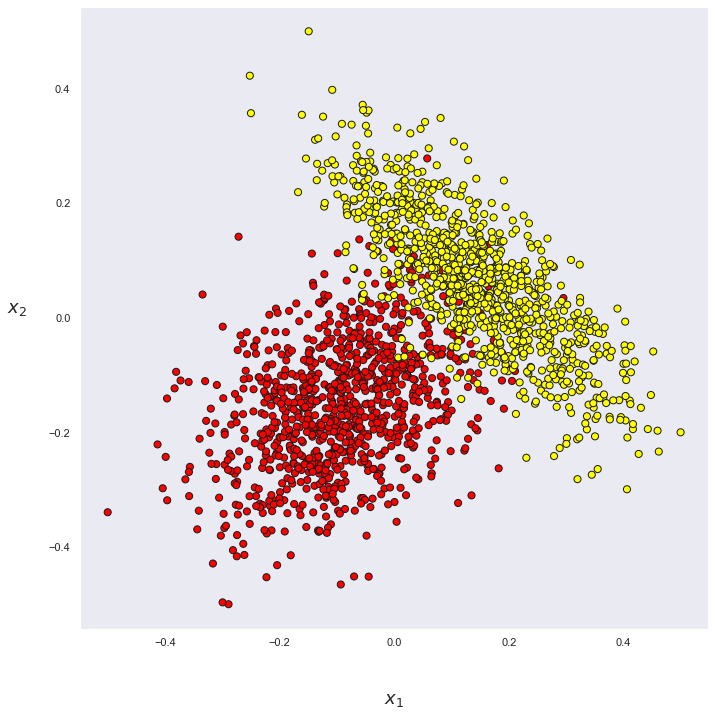

In [5]:
fig = plt.figure(figsize = (10, 10))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=cm_bright, edgecolors='k')
ax = plt.gca()
ax.axis('equal')
ax.set_xlabel('$x_{1}$',fontsize=18)
ax.set_ylabel('$x_{2}$',rotation=0,fontsize=18)
ax.xaxis.set_label_coords(0.5, -0.1)
ax.yaxis.set_label_coords(-0.1, 0.5)        
ax.grid(None)
fig.tight_layout()

plt.savefig('7.2.1_Overlapping_blobs_dataset.png')
plt.savefig('7.2.1_Overlapping_blobs_dataset.pdf')

## Part II: MLP training and performance assessment

### Define a training function that saves loss, score and weight statistics for each epoch.  

In [6]:
def train_MLP(X_train, y_train, X_test, y_test, n_epochs, params):

    # We use a MLP with a single neuron in the hidden layer
    clf = MLPClassifier(random_state=0, max_iter=400, hidden_layer_sizes =1, **params)

    N_TRAIN_SAMPLES = X_train.shape[0]
    N_BATCH = 200
    N_CLASSES = np.unique(y_train)

    scores_train = []
    scores_test = []
    loss_train = []
    loss_test = []
    w0 = []
    w1 = []

    epoch = 0
    while epoch < n_epochs:
        # Shuffle the training dataset
        random_perm = np.random.permutation(X_train.shape[0])
        mini_batch_index = 0
        while True:
            # Train over a mini bach
            indices = random_perm[mini_batch_index:mini_batch_index + N_BATCH]
            clf.partial_fit(X_train[indices], y_train[indices], classes=N_CLASSES)
            mini_batch_index += N_BATCH

            if mini_batch_index >= N_TRAIN_SAMPLES:
                break

        # Training scores
        scores_train.append(clf.score(X_train, y_train))
        loss_train.append(clf.loss_)

        # Test scores
        scores_test.append(clf.score(X_test, y_test))
        y_pred = clf.predict(X_test)
        loss_test.append(log_loss(y_test, y_pred))

        # Weights of the neuron in the hidden layer
        w0.append(clf.coefs_[0][0][0])
        w1.append(clf.coefs_[0][1][0])
        
        epoch += 1

    return (scores_train, loss_train, scores_test, loss_test, w0, w1, clf)

### Train the MLP using two different optimizing methods
The MLP using the SGD optimizer was longer to train and ran over 150 epochs before the training loss levelled out. 
The MLP using the SGD with momentum converged faster and was trained over 40 epochs.

In [7]:
params = {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': 0.0, 'learning_rate_init': 0.2}
n_epochs = 150
(scores_train_1, loss_train_1, scores_test_1, loss_test_1, w0_1, w1_1, clf_1) = train_MLP(X_train, y_train, X_test, y_test, n_epochs, params)


params = {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': 0.9, 'learning_rate_init': 0.2, 'nesterovs_momentum': False}
n_epochs = 40
(scores_train_2, loss_train_2, scores_test_2, loss_test_2, w0_2, w1_2, clf_2) = train_MLP(X_train, y_train, X_test, y_test, n_epochs, params)


### Compare the results for both optimizing methods.
The loss and accuracy results were averaged over the last 10 epochs of each curve. They are almost identical.

In [8]:
print("SGD:")
print("   Training: loss = %.3f  accuracy = %.3f " % (np.mean(loss_train_1[-10:-1]),np.mean(scores_train_1[-10:-1])))
print("   Test:     loss = %.3f  accuracy = %.3f\n" % (np.mean(loss_test_1[-10:-1]),np.mean(scores_test_1[-10:-1])))

print("SGD with momentum:")
print("   Training: loss = %.3f  accuracy = %.3f " % (np.mean(loss_train_2[-10:-1]),np.mean(scores_train_2[-10:-1])))
print("   Test:     loss = %.3f  accuracy = %.3f\n" % (np.mean(loss_test_2[-10:-1]),np.mean(scores_test_2[-10:-1])))


SGD:
   Training: loss = 0.149  accuracy = 0.952 
   Test:     loss = 1.698  accuracy = 0.951

SGD with momentum:
   Training: loss = 0.146  accuracy = 0.950 
   Test:     loss = 1.708  accuracy = 0.951



## Part III: Show training results

### Compare the training loss curves
MLP training with the SGD optimizer with momentum converged faster than with the SGD optimizer alone. Both trainings 
were stopped when their average loss levelled out. 

N.B. Smoother results could be obtained using more data points and other optimizing methods.

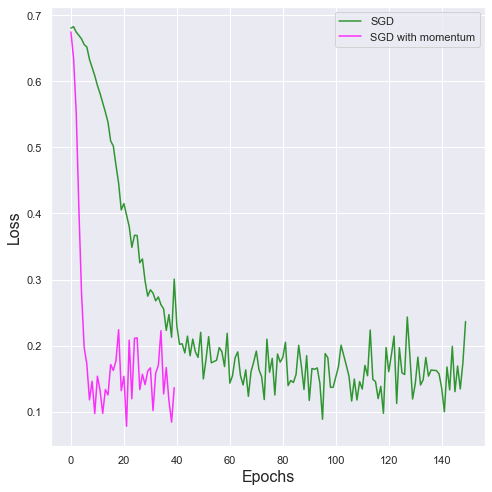

In [9]:
fig, ax = plt.subplots(1,1, figsize=(7,7), sharex=True) 
ax.plot(loss_train_1, color='green', alpha=0.8, label='SGD') 
ax.plot(loss_train_2, color='magenta', alpha=0.8, label='SGD with momentum') 
ax.set_xlabel('Epochs', fontsize=16)
ax.set_ylabel('Loss', fontsize=16)
ax.legend(loc='upper right')
fig.tight_layout()    

plt.savefig('7.2.2_MLP_Training_loss_curves.png')
plt.savefig('7.2.2_MLP_Training_loss_curves.pdf')

### Compare the training and test loss curves for each optimizing method
The first panel below shows the test loss to go through a minimum before increasing again, a sign of overfitting. 
We should stop the iterations when the minimum is found, at epoch 70 in this example. 

No minimum in test loss is visible in the second panel.

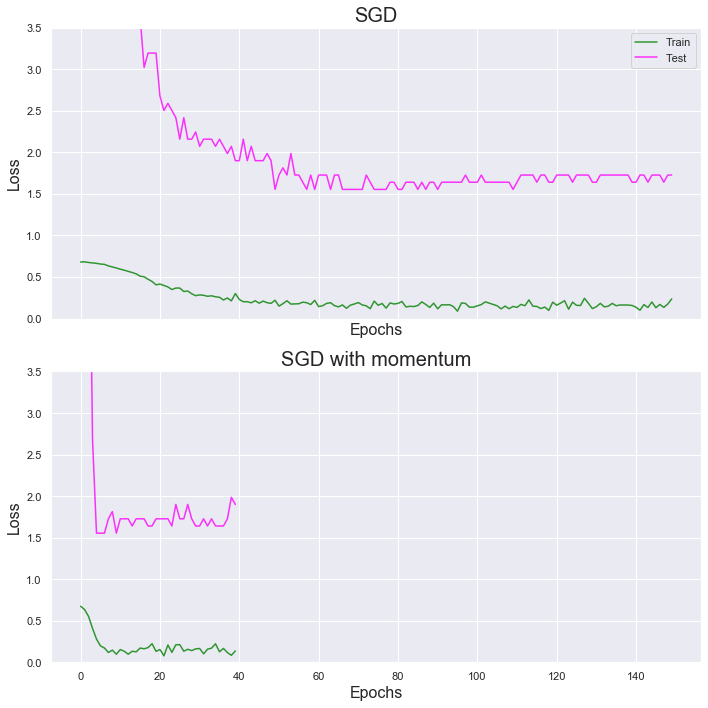

In [10]:
fig, ax = plt.subplots(2,1, figsize=(10,10), sharex=True) 
ax[0].plot(loss_train_1, color='green', alpha=0.8, label='Train') 
ax[0].plot(loss_test_1, color='magenta', alpha=0.8, label='Test') 
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Loss', fontsize=16)
ax[0].legend(loc='upper right')
ax[0].set_ylim([0, 3.5])
ax[0].set_title('SGD', fontsize=20)

ax[1].plot(loss_train_2, color='green', alpha=0.8, label='Train')
ax[1].plot(loss_test_2, color='magenta', alpha=0.8, label='Test')
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].set_title('SGD with momentum', fontsize=20)
ax[1].set_ylim([0, 3.5])
fig.tight_layout() 

plt.savefig('7.2.3_MLP_training_test_loss_curves_comparison.png')
plt.savefig('7.2.3_MLP_training_test_loss_curves_comparison.pdf')

### Compare the training and test accuracies for each optimizing method
The first panel below shows that the test accuracy reached a maximum when the test loss reached a minimum (at epoch 70) 
and decreased afterwards. Beyond that point, the MLP started to overfit as it "memorized" the training dataset. 
Its generalisation performances decreased and led to reduced performances.

The second panel shows that both training and test produce similar results.


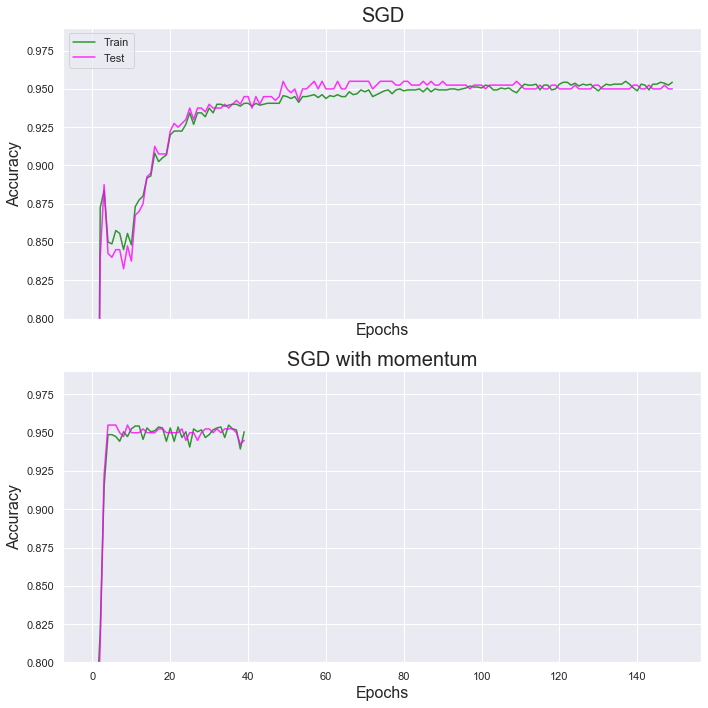

In [11]:
fig, ax = plt.subplots(2,1, figsize=(10,10), sharex=True)
ax[0].plot(scores_train_1, color='green', alpha=0.8, label='Train')
ax[0].plot(scores_test_1, color='magenta', alpha=0.8, label='Test')
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend(loc='upper left')
ax[0].set_ylim([.8, .99])
ax[0].set_title('SGD', fontsize=20)

ax[1].plot(scores_train_2, color='green', alpha=0.8, label='Train')
ax[1].plot(scores_test_2, color='magenta', alpha=0.8, label='Test')
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Accuracy', fontsize=16)
ax[1].set_ylim([.8, .99])
ax[1].set_title('SGD with momentum', fontsize=20)
fig.tight_layout() 

plt.savefig('7.2.4_MLP_training_test_accuracy_curves_comparison.png')
plt.savefig('7.2.4_MLP_training_test_loss_curves_comparison.pdf')

### Show the weight trajectory of the neuron in the hidden layer during optimization.
In each panel, the weight values $(w_{1}, w_{2})$ are printed as dots, one for each epoch. The right panel shows 
a faster convergence for the SGD + momentum optimizer. It converged toward its optimal w value in the upper-right corner. 

In both panels, the weight trajectories are well behaved, i.e. not chaotic. Notice that the final w values are 
slightly different. The two optimizations have reached neighboring minima in loss that have similar values.  


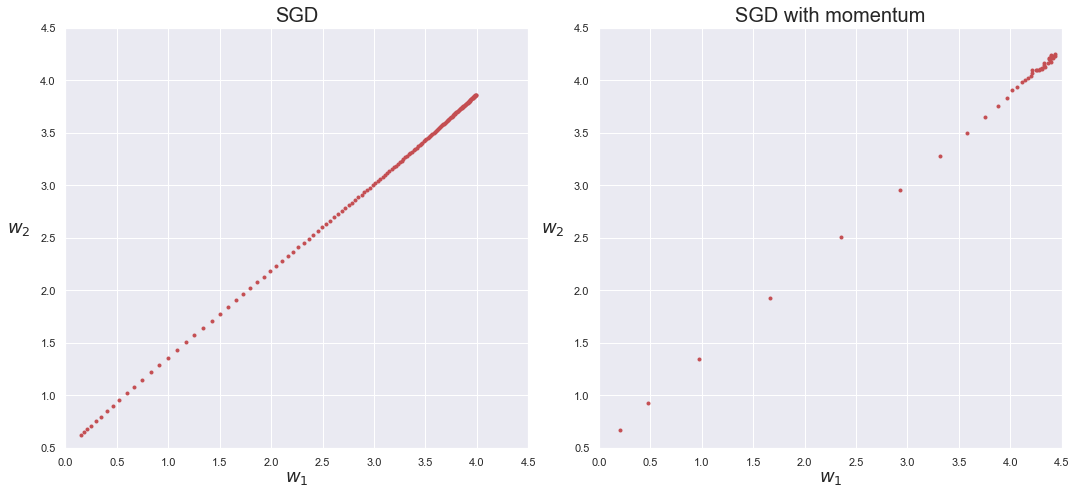

In [12]:
fig, ax = plt.subplots(1,2, figsize=(15,7)) 
ax[0].plot(w0_1, w1_1, '.', color='r')
ax[0].set_xlabel('$w_{1}$', fontsize=18)
ax[0].set_ylabel('$w_{2}$', fontsize=18, rotation=0)
ax[0].xaxis.set_label_coords(0.5, -0.05) 
ax[0].yaxis.set_label_coords(-0.1, 0.5)
ax[0].set_xlim([0, 4.5])
ax[0].set_ylim([.5, 4.5])
ax[0].set_title('SGD', fontsize=20)

ax[1].plot(w0_2, w1_2, '.', color='r')
ax[1].set_xlabel('$w_{1}$', fontsize=18)
ax[1].set_ylabel('$w_{2}$', fontsize=18, rotation=0)
ax[1].xaxis.set_label_coords(0.5, -0.05) 
ax[1].yaxis.set_label_coords(-0.1, 0.5)
ax[1].set_xlim([0, n_epochs])
ax[1].set_ylim([0, .99])
ax[1].set_xlim([0, 4.5])
ax[1].set_ylim([.5, 4.5])
ax[1].set_title('SGD with momentum', fontsize=20)
fig.tight_layout()

plt.savefig('7.2.5_MLP_Neuron_weight_trajectory.png')
plt.savefig('7.2.5_MLP_Neuron_weight_trajectory.pdf')

### Show the MLP classification results for each optimization method
Very similar results can be seen in the two panels. However, the SGD-with-momentum optimizer took about 4 X less iterations
to converge.


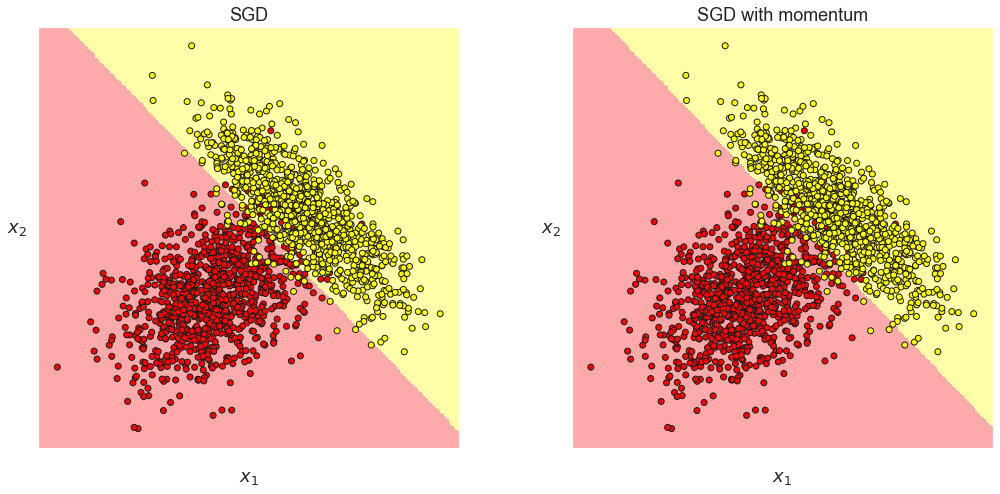

In [13]:
# Determine the class over the spatial grid
Z1 = clf_1.predict(Xgrid) 
Z1 = Z1.reshape(xx.shape)
Z2 = clf_2.predict(Xgrid) 
Z2 = Z2.reshape(xx.shape)

fig, ax = plt.subplots(1,2, figsize=(15,7)) 
ax[0].pcolormesh(xx, yy, Z1, cmap=cm_dim, norm=colors.Normalize(0., 1.), zorder=0) 
ax[0].scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, edgecolors='k')
ax[0].set_xlabel('$x_{1}$', fontsize=18)
ax[0].set_ylabel('$x_{2}$', fontsize=18, rotation=0) 
ax[0].xaxis.set_label_coords(0.5, -0.05) 
ax[0].yaxis.set_label_coords(-0.05, 0.5) 
ax[0].set_aspect('equal')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].grid(None)  
ax[0].set_title('SGD',fontsize=18)

ax[1].pcolormesh(xx, yy, Z2, cmap=cm_dim, norm=colors.Normalize(0., 1.), zorder=0) 
ax[1].scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, edgecolors='k')
ax[1].set_xlabel('$x_{1}$', fontsize=18)
ax[1].set_ylabel('$x_{2}$', fontsize=18, rotation=0) 
ax[1].xaxis.set_label_coords(0.5, -0.05) 
ax[1].yaxis.set_label_coords(-0.05, 0.5) 
ax[1].set_aspect('equal')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].grid(None)  
ax[1].set_title('SGD with momentum',fontsize=18)
fig.tight_layout()

plt.savefig('7.2.6_MLP_classification_comparison.png')
plt.savefig('7.2.6_MLP_classification_comparison.png')